In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import glob
import math
%matplotlib inline

#cv
import cv2
import math
from PIL import Image
import math
from scipy import ndimage
import argparse
import imutils


#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from matplotlib import font_manager, rc
rc('font',family="AppleGothic")
plt.rcParams["font.family"]="AppleGothic" #plt 한글꺠짐
plt.rcParams["font.family"]="Arial" #외국어꺠짐
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 출력 설정
plt.rc('figure', figsize=(10,8))

sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid') #sns 한글깨짐

In [2]:
def show(img):
    #사이즈
    plt.figure(figsize = (10,8))
    #xticks/yticks - 눈금표
    plt.xticks([])
    plt.yticks([])
    #코랩에서 안돌아감 주의
    plt.imshow(img, cmap= 'gray')
    plt.show()

In [3]:
#이미지 수 확인하기
def count_img(path):
    data_path = os.path.join(path, '*g')
    files= glob.glob(data_path)
    img_list=[]
    for f1 in files:
        img = cv2.imread(f1)
        img_list.append(img)
    print('이미지수',len(img_list)) 

In [4]:
#이미지 불러오기
def get_img(path):
    data_path = os.path.join(path, '*g')
    files= glob.glob(data_path)
    img_list=[]
    for f1 in files:
        img = cv2.imread(f1)
        img_list.append(img)
#     print('이미지수',len(img_list))
#     print('show(get_img(list_file[1])[0]) 식으로 이미지 불러와서 img로 저장')
    
    return img_list
    
# data_img = get_img(list_file[2])
# show(img_list[1])

In [5]:
org_img_path ='/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/'

In [6]:
file_list = os.listdir(org_img_path)
file_list.sort()
file_list = file_list[1:]
list_file = []
for i in file_list:
    list_file.append(org_img_path+i)
list_file.sort()
# list_file

In [9]:
#masking, return 까먹지 말기 흑흑 
def get_mask(img):
    # #마스크 생성을 위해, 밝기 강조한 Lab으로 이미지 변환 01
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    # #블러 02
    # #블러의 커널 사이즈가 홀수만 가능하므로 이미지 평균 값을 기준으로 홀수값 만들기
    blur_k = int((img.mean()*0.5)//2)*2+1 
    img = cv2.medianBlur(img, blur_k)
    # #threshold 적용을 위해 Lab에서 Grayscale로 이미지 변환 03
    img = cv2.cvtColor(img, cv2.COLOR_Lab2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # #이미지 평균값을 기준으로 이진화 04
    ret, img = cv2.threshold(img, img.mean()*1.1, 255, cv2.THRESH_BINARY)

    # # #가장 큰 값의 컨투어로 마스크 만들기 05
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask = cv2.dilate(mask,k)
    return mask

#img_cropping 
def get_cropped_mask(img, mask):
    """
    마스크를 기준으로 경계선을 찾아 위/왼/오른쪽을 자루는 함수로서
    img = original image
    mask = bit_img
    cropped_img = 원본 이미지에서 마크된 영역을 갖는 부분 반환
    """
    
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = img_.shape
    
    #마스크 기준으로 위/왼/오른쪽 경계선 찾기(숫자로 확인 가능)
    mask_list = mask.tolist()
    
    #테두리가 흰색인 경우를 고려해서, 테두리에서 5% 지점부터 경계점 찾기 시작
    #경계점은 중간 부분(30~70%)에서 검은색(0)을 벗어난 지점을 기준으로 함
    #위쪽
    for y in range(int(height*0.05), height): #마스크이미지에서, 일반 이미지의 5%이상의 지점에서 
    #가로는 30%-70%까지가 0보다 클때 (마스크의 max값이 - 그 범위에 1(흰색)이 있을때)
        if max(mask[y,int(width*0.3):int(width*0.7)]) >0:
        #총 mask 이미지에서, 일반이미지에서 5%더한 값을 뺌
            start_y = y-int(height*0.05)
            break
    
    #왼쪽 start point
    for x in range(int(width*0.05),width):
        if max(mask[x,int(height*0.3):int(height*0.7)]) >0:
            start_x = x-int(width*0.05)
            break

    # #오른쪽, stop, -1,-1(오른쪽에서 왼쪽으로)
    for x in range(int(width*0.95),-1,-1):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            end_x = x+int(width*0.05)
            break

    #경계선 기준으로 이미지와 마스크 자름
    img_ = img_[start_y:,start_x:end_x]
    mask = mask[start_y:,start_x:end_x]

    img = cv2.bitwise_and(img_, mask)
    
    return img

def wrist_cut(img):
    height = img.shape[0]
    width = img.shape[1]

    #이미지의 아래에서부터 시작해서 화소 평균이 커지는(밝아지는) 경계선 찾기
    start = int(height*0.95)  #아래 테두리가 밝은 경우를 고려해서 height*0.95부터 시작함
    index = 0
    k = 10 #10개 행씩 평균 구함
    while True:
        pixel_lower = img[start-k*(index+1):start-k*index,:].mean()
        pixel_upper = img[start-k*(index+2):start-k*(index+1),:].mean()
        if pixel_upper - pixel_lower > 0:
            end_y = start-k*(index+1)
            break
        index += 1

    img = img[:end_y]
    return img

def mask_for_center(img):
    blur_k = int((img.mean()*0.5)//2)*2+1 
    img = cv2.medianBlur(img, blur_k)

    # #이미지 평균값을 기준으로 이진화 04
    ret, img = cv2.threshold(img, img.mean()*1.1, 255, cv2.THRESH_BINARY)

    # # #가장 큰 값의 컨투어로 마스크 만들기 05
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask = cv2.dilate(mask,k)
    return mask



#img_preprocessing
def blake_back(img):
    mask =get_mask(img)
    black_back = get_cropped_mask(img, mask)
    black_back = wrist_cut(black_back)
    center_mask = mask_for_center(black_back)
    return black_back, center_mask

In [10]:
img = get_img(list_file[1])[2]
black_back, center_mask = blake_back(img)

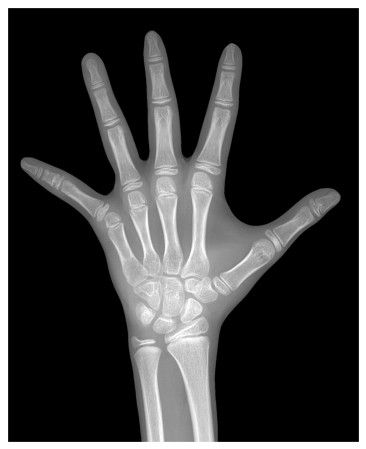

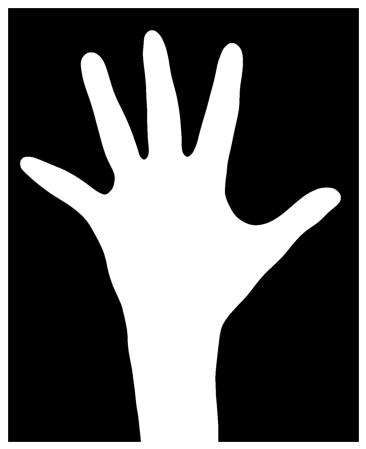

In [11]:
show(black_back)
show(center_mask)

In [12]:
def get_center(center_mask):
#     mask = mask_for_center(img)
    res, thresh = cv2.threshold(center_mask, center_mask.mean(), 255, cv2.THRESH_BINARY)

    # find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # loop over the contours
    for c in cnts:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    
    return cX, cY

def get_far_list(img):
    #손가락포인트
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(max_cnt, returnPoints = False)
    defects = cv2.convexityDefects(max_cnt, hull)
    
    far_list = []
    for i in range(defects.shape[0]):
        s,e,f,d = defects[i,0]
        start = tuple(max_cnt[s][0])
        end = tuple(max_cnt[e][0])
        far = tuple(max_cnt[f][0])
        far_list.append(far)
        
    return far_list

def get_thumbs_point(far_list):
    far_list.sort(key = lambda x:x[0])
    thX, thY = far_list[-1]
    return thX, thY

#point
def get_thumbs_finger_point(center_mask, black_back):
    cX, cY = get_center(center_mask)
    far_list = get_far_list(black_back)
    thX, thY = get_thumbs_point(far_list)
    return cX, cY, thX, thY

In [13]:
img = get_img(list_file[1])[2]
black_back, center_mask = blake_back(img)
cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
print(cX, cY, thX, thY)

629 865 1245 705


In [14]:
img = get_img(list_file[7])[5]
black_back, center_mask = blake_back(img)
cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
print(cX, cY, thX, thY)

404 529 687 336


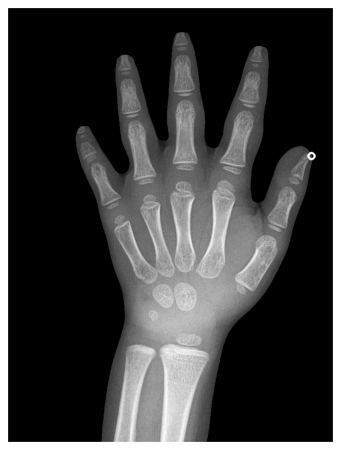

In [15]:
img_th = cv2.circle(black_back, (thX, thY), 7,(255,0,0),3)
show(img_th)

#thx, thY 점에서 손가락 추출 rotation 없이

In [17]:
img_test = img_th.copy()

In [36]:
def rotation_cut(img):
    img = ndimage.rotate(img, 70)
    ret, th = cv2.threshold(img, img.mean(), 255, cv2.THRESH_BINARY)
    th_l = th.tolist()
    cut_index = 0
    if th_l[0][0] == 0 or th_l[0][-1] == 0:
        for i in reversed(range(len(th_l))):
            if th_l[i].count(255) > 0:
                cut_index = i

    img = img[cut_index:]
    return img

def center_img(img):
    imgY, imgX = img.shape[:2]
    imgY = int((imgY)/2)
    imgX = int(imgX/2)
    
    return imgY, imgX

In [ ]:
def thumbs_rotation(img):
    angle = math.degrees(math.atan2(cY-thY, cX-thX))
    img = ndimage.rotate(img, angle-100)#시계방향
    return img

def rotation_cut(img):
    ret, th = cv2.threshold(img, img.mean(), 255, cv2.THRESH_BINARY)
    th_l = th.tolist()
    cut_index = 0
    if th_l[0][0] == 0 or th_l[0][-1] == 0:
        for i in reversed(range(len(th_l))):
            if th_l[i].count(255) > 0:
                cut_index = i

    img = img[cut_index:]
    return img

def center_img(img):
    imgY, imgX = img.shape[:2]
    imgY = int((imgY)/2)
    imgX = int(imgX/2)
    
    return imgY, imgX


#rotation / get_imgYX
def get_imgYX(img):
    rotated_img = thumbs_rotation(img)
    show(rotated_img)
    img = rotation_cut(rotated_img)
    show(img)
    imgY, imgX = center_img(img)
    return img, imgY, imgX

In [57]:
def get_thumbs_croped(img):
    ret, thresh = cv2.threshold(img, thumbs.mean(), 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_xy = np.array(contours)

    # x의 min과 max 찾기
    x_min, x_max = 0,0
    value = list()
    for i in range(len(contours_xy)):
        for j in range(len(contours_xy[i])):
            value.append(contours_xy[i][j][0][0]) #네번째 괄호가 0일때 x의 값
            x_min = min(value)
            x_max = max(value)
#     print(x_min)
#     print(x_max)

    # y의 min과 max 찾기
    y_min, y_max = 0,0
    value = list()
    for i in range(len(contours_xy)):
        for j in range(len(contours_xy[i])):
            value.append(contours_xy[i][j][0][1]) #네번째 괄호가 0일때 x의 값
            y_min = min(value)
            y_max = max(value)
#     print(y_min)
#     print(y_max)

    # image trim 하기
    x = x_min
    y = y_min
    w = x_max-x_min
    h = y_max-y_min

    img_trim = img[y:y+h, x:x+w]
    
    return img_trim 

#### test

560 776 1017 572


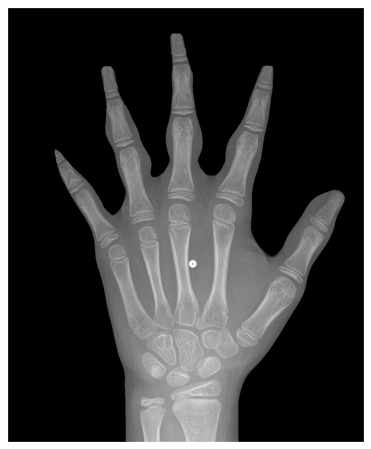

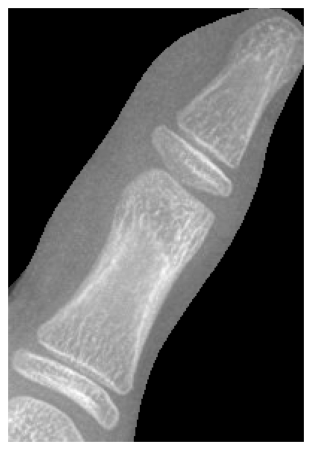

In [59]:
img = get_img(list_file[0])[10]
black_back, center_mask = blake_back(img)
# show(black_back)
cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
print(cX, cY, thX, thY)
img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
show(img_point)
thumbs = black_back[thY-30:cY+70, thX-200:thX]
thumbs_fin = get_thumbs_croped(thumbs)
show(thumbs_fin)

492 629 908 412


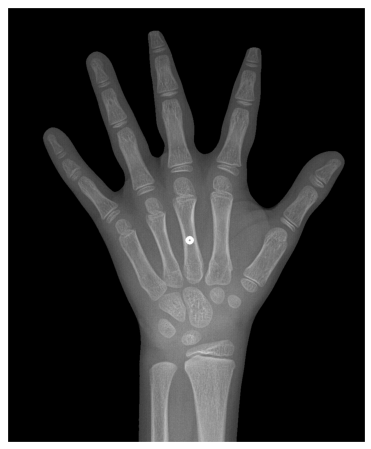

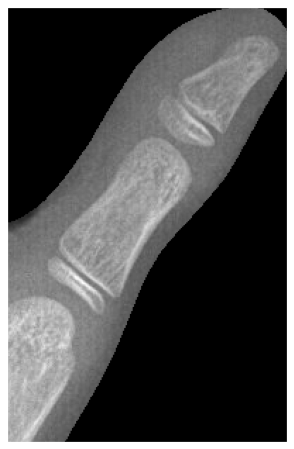

In [58]:
img = get_img(list_file[10])[10]
black_back, center_mask = blake_back(img)
# show(black_back)
cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
print(cX, cY, thX, thY)
img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
show(img_point)
thumbs = black_back[thY-30:cY+70, thX-200:thX]
thumbs_fin = get_thumbs_croped(thumbs)
show(thumbs_fin)

#### extraction

In [60]:
list_file

['/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_10yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_11yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_12yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_13yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_14yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_15yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_16yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_3yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_4yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_5yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_

In [93]:
print(list_file[0])

img_path = os.path.join(list_file[0],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[0])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_10yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_10yr
['320_F', '358_F', '339_F', '341_F', '343_F', '322_F', '326_F', '347_F', '345_F', '324_F', '319_F', '342_F', '323_F', '359_F', '321_F', '340_F', '338_F', '344_F', '318_F', '325_F', '327_F', '346_F', '332_F', '316_F', '353_F', '329_F', '314_F', '351_F', '330_F', '348_F', '334_F', '310_F', '355_F', '312_F', '357_F', '336_F', '350_F', '315_F', '328_F', '349_F', '331_F', '333_F', '352_F', '317_F', '356_F', '313_F', '337_F', '335_F', '354_F', '311_F']
51 개
320_F완료 1번째 완료


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


358_F완료 2번째 완료
339_F완료 3번째 완료
341_F완료 4번째 완료
343_F완료 5번째 완료
322_F완료 6번째 완료
326_F완료 7번째 완료
347_F완료 8번째 완료
345_F완료 9번째 완료
324_F완료 10번째 완료
319_F완료 11번째 완료
342_F완료 12번째 완료
323_F완료 13번째 완료
359_F완료 14번째 완료
321_F완료 15번째 완료
340_F완료 16번째 완료
338_F완료 17번째 완료
344_F완료 18번째 완료
318_F완료 19번째 완료
325_F완료 20번째 완료
327_F완료 21번째 완료
346_F완료 22번째 완료
332_F완료 23번째 완료
316_F완료 24번째 완료
353_F완료 25번째 완료
329_F완료 26번째 완료
314_F완료 27번째 완료
351_F완료 28번째 완료
330_F완료 29번째 완료
348_F완료 30번째 완료
334_F완료 31번째 완료
310_F완료 32번째 완료
355_F완료 33번째 완료
312_F완료 34번째 완료
357_F완료 35번째 완료
336_F완료 36번째 완료
350_F완료 37번째 완료
315_F완료 38번째 완료
328_F완료 39번째 완료
349_F완료 40번째 완료
331_F완료 41번째 완료
333_F완료 42번째 완료
352_F완료 43번째 완료
317_F완료 44번째 완료
356_F완료 45번째 완료
313_F완료 46번째 완료
337_F완료 47번째 완료
335_F완료 48번째 완료
354_F완료 49번째 완료
311_F완료 50번째 완료
끝 51 개


In [94]:
print(list_file[1])

img_path = os.path.join(list_file[1],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[1])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_11yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_11yr
['398_F', '365_F', '381_F', '383_F', '367_F', '363_F', '387_F', '378_F', '385_F', '409_F', '361_F', '382_F', '366_F', '399_F', '364_F', '380_F', '379_F', '384_F', '408_F', '360_F', '362_F', '386_F', '377_F', '393_F', '406_F', '404_F', '391_F', '375_F', '388_F', '371_F', '395_F', '368_F', '400_F', '402_F', '397_F', '373_F', '405_F', '390_F', '374_F', '389_F', '376_F', '392_F', '407_F', '403_F', '396_F', '372_F', '370_F', '394_F', '369_F', '401_F']
51 개
398_F완료 1번째 완료


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


365_F완료 2번째 완료
381_F완료 3번째 완료
383_F완료 4번째 완료
367_F완료 5번째 완료
363_F완료 6번째 완료
387_F완료 7번째 완료
378_F완료 8번째 완료
385_F완료 9번째 완료
409_F완료 10번째 완료
361_F완료 11번째 완료
382_F완료 12번째 완료
366_F완료 13번째 완료
399_F완료 14번째 완료
364_F완료 15번째 완료
380_F완료 16번째 완료
379_F완료 17번째 완료
384_F완료 18번째 완료
408_F완료 19번째 완료
360_F완료 20번째 완료
362_F완료 21번째 완료
386_F완료 22번째 완료
377_F완료 23번째 완료
393_F완료 24번째 완료
406_F완료 25번째 완료
404_F완료 26번째 완료
391_F완료 27번째 완료
375_F완료 28번째 완료
388_F완료 29번째 완료
371_F완료 30번째 완료
395_F완료 31번째 완료
368_F완료 32번째 완료
400_F완료 33번째 완료
402_F완료 34번째 완료
397_F완료 35번째 완료
373_F완료 36번째 완료
405_F완료 37번째 완료
390_F완료 38번째 완료
374_F완료 39번째 완료
389_F완료 40번째 완료
376_F완료 41번째 완료
392_F완료 42번째 완료
407_F완료 43번째 완료
403_F완료 44번째 완료
396_F완료 45번째 완료
372_F완료 46번째 완료
370_F완료 47번째 완료
394_F완료 48번째 완료
369_F완료 49번째 완료
401_F완료 50번째 완료
끝 51 개


In [95]:
print(list_file[2])

img_path = os.path.join(list_file[2],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[2])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_12yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_12yr
['448_F', '430_F', '414_F', '451_F', '429_F', '416_F', '453_F', '432_F', '436_F', '412_F', '457_F', '410_F', '455_F', '434_F', '452_F', '417_F', '433_F', '431_F', '449_F', '428_F', '450_F', '415_F', '454_F', '411_F', '435_F', '437_F', '456_F', '413_F', '422_F', '443_F', '441_F', '439_F', '458_F', '420_F', '419_F', '424_F', '445_F', '447_F', '426_F', '438_F', '440_F', '421_F', '459_F', '423_F', '442_F', '446_F', '427_F', '425_F', '418_F', '444_F']
51 개
448_F완료 1번째 완료
430_F완료 2번째 완료
414_F완료 3번째 완료
451_F완료 4번째 완료
429_F완료 5번째 완료
416_F완료 6번째 완료
453_F완료 7번째 완료
432_F완료 8번째 완료
436_F완료 9번째 완료
412_F완료 10번째 완료
457_F완료 11번째 완료


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


410_F완료 12번째 완료
455_F완료 13번째 완료
434_F완료 14번째 완료
452_F완료 15번째 완료
417_F완료 16번째 완료
433_F완료 17번째 완료
431_F완료 18번째 완료
449_F완료 19번째 완료
428_F완료 20번째 완료
450_F완료 21번째 완료
415_F완료 22번째 완료
454_F완료 23번째 완료
411_F완료 24번째 완료
435_F완료 25번째 완료
437_F완료 26번째 완료
456_F완료 27번째 완료
413_F완료 28번째 완료
422_F완료 29번째 완료
443_F완료 30번째 완료
441_F완료 31번째 완료
439_F완료 32번째 완료
458_F완료 33번째 완료
420_F완료 34번째 완료
419_F완료 35번째 완료
424_F완료 36번째 완료
445_F완료 37번째 완료
447_F완료 38번째 완료
426_F완료 39번째 완료
438_F완료 40번째 완료
440_F완료 41번째 완료
421_F완료 42번째 완료
459_F완료 43번째 완료
423_F완료 44번째 완료
442_F완료 45번째 완료
446_F완료 46번째 완료
427_F완료 47번째 완료
425_F완료 48번째 완료
418_F완료 49번째 완료
444_F완료 50번째 완료
끝 51 개


In [96]:
print(list_file[3])

img_path = os.path.join(list_file[3],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[3])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_13yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_13yr
['475_F', '488_F', '491_F', '493_F', '477_F', '473_F', '497_F', '495_F', '468_F', '471_F', '492_F', '476_F', '474_F', '489_F', '490_F', '494_F', '469_F', '470_F', '472_F', '496_F', '467_F', '502_F', '483_F', '481_F', '500_F', '498_F', '465_F', '504_F', '461_F', '478_F', '485_F', '487_F', '463_F', '480_F', '499_F', '464_F', '501_F', '503_F', '466_F', '482_F', '486_F', '462_F', '460_F', '479_F', '484_F']
46 개
475_F완료 1번째 완료


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


488_F완료 2번째 완료
491_F완료 3번째 완료
493_F완료 4번째 완료
477_F완료 5번째 완료
473_F완료 6번째 완료
497_F완료 7번째 완료
495_F완료 8번째 완료
468_F완료 9번째 완료
471_F완료 10번째 완료
492_F완료 11번째 완료
476_F완료 12번째 완료
474_F완료 13번째 완료
489_F완료 14번째 완료
490_F완료 15번째 완료
494_F완료 16번째 완료
469_F완료 17번째 완료
470_F완료 18번째 완료
472_F완료 19번째 완료
496_F완료 20번째 완료
467_F완료 21번째 완료
502_F완료 22번째 완료
483_F완료 23번째 완료
481_F완료 24번째 완료
500_F완료 25번째 완료
498_F완료 26번째 완료
465_F완료 27번째 완료
504_F완료 28번째 완료
461_F완료 29번째 완료
478_F완료 30번째 완료
485_F완료 31번째 완료
487_F완료 32번째 완료
463_F완료 33번째 완료
480_F완료 34번째 완료
499_F완료 35번째 완료
464_F완료 36번째 완료
501_F완료 37번째 완료
503_F완료 38번째 완료
466_F완료 39번째 완료
482_F완료 40번째 완료
486_F완료 41번째 완료
462_F완료 42번째 완료
460_F완료 43번째 완료
479_F완료 44번째 완료
484_F완료 45번째 완료
끝 46 개


In [97]:
print(list_file[4])

img_path = os.path.join(list_file[4],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[4])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_14yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_14yr
['510_F', '509_F', '534_F', '536_F', '512_F', '516_F', '532_F', '530_F', '514_F', '529_F', '537_F', '513_F', '511_F', '535_F', '508_F', '531_F', '528_F', '515_F', '517_F', '533_F', '526_F', '519_F', '524_F', '539_F', '520_F', '522_F', '506_F', '525_F', '518_F', '527_F', '523_F', '507_F', '538_F', '505_F', '540_F', '521_F']
37 개
510_F완료 1번째 완료
509_F완료 2번째 완료
534_F완료 3번째 완료
536_F완료 4번째 완료
512_F완료 5번째 완료


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


516_F완료 6번째 완료
532_F완료 7번째 완료
530_F완료 8번째 완료
514_F완료 9번째 완료
529_F완료 10번째 완료
537_F완료 11번째 완료
513_F완료 12번째 완료
511_F완료 13번째 완료
535_F완료 14번째 완료
508_F완료 15번째 완료
531_F완료 16번째 완료
528_F완료 17번째 완료
515_F완료 18번째 완료
517_F완료 19번째 완료
533_F완료 20번째 완료
526_F완료 21번째 완료
519_F완료 22번째 완료
524_F완료 23번째 완료
539_F완료 24번째 완료
520_F완료 25번째 완료
522_F완료 26번째 완료
506_F완료 27번째 완료
525_F완료 28번째 완료
518_F완료 29번째 완료
527_F완료 30번째 완료
523_F완료 31번째 완료
507_F완료 32번째 완료
538_F완료 33번째 완료
505_F완료 34번째 완료
540_F완료 35번째 완료
521_F완료 36번째 완료
끝 37 개


In [98]:
print(list_file[5])

img_path = os.path.join(list_file[5],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[5])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_15yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_15yr
['555_F', '557_F', '553_F', '548_F', '551_F', '556_F', '554_F', '549_F', '550_F', '552_F', '547_F', '545_F', '541_F', '558_F', '543_F', '544_F', '546_F', '542_F', '559_F']
20 개
555_F완료 1번째 완료
557_F완료 2번째 완료
553_F완료 3번째 완료
548_F완료 4번째 완료
551_F완료 5번째 완료


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


556_F완료 6번째 완료
554_F완료 7번째 완료
549_F완료 8번째 완료
550_F완료 9번째 완료
552_F완료 10번째 완료
547_F완료 11번째 완료
545_F완료 12번째 완료
541_F완료 13번째 완료
558_F완료 14번째 완료
543_F완료 15번째 완료
544_F완료 16번째 완료
546_F완료 17번째 완료
542_F완료 18번째 완료
559_F완료 19번째 완료
끝 20 개


In [99]:
print(list_file[6])

img_path = os.path.join(list_file[6],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[6])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_16yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_16yr
['568_F', '571_F', '569_F', '570_F', '563_F', '561_F', '565_F', '567_F', '560_F', '562_F', '566_F', '564_F']
13 개
568_F완료 1번째 완료
571_F완료 2번째 완료
569_F완료 3번째 완료
570_F완료 4번째 완료
563_F완료 5번째 완료
561_F완료 6번째 완료
565_F완료 7번째 완료
567_F완료 8번째 완료
560_F완료 9번째 완료
562_F완료 10번째 완료
566_F완료 11번째 완료
564_F완료 12번째 완료
끝 13 개


In [69]:
print(list_file[7])
img_path = os.path.join(list_file[7],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img = get_img(list_file[7])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-30:cY+75, thX-150:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_3yr_thumbs/thumbs_3_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_3yr
['8_F', '16_F', '14_F', '10_F', '12_F', '15_F', '17_F', '9_F', '13_F', '11_F', '3_F', '1_F', '5_F', '19_F', '7_F', '2_F', '6_F', '18_F', '4_F']


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


8_F완료 1번째 완료
16_F완료 2번째 완료
14_F완료 3번째 완료
10_F완료 4번째 완료
12_F완료 5번째 완료
15_F완료 6번째 완료
17_F완료 7번째 완료
9_F완료 8번째 완료
13_F완료 9번째 완료
11_F완료 10번째 완료
3_F완료 11번째 완료
1_F완료 12번째 완료
5_F완료 13번째 완료
19_F완료 14번째 완료
7_F완료 15번째 완료
2_F완료 16번째 완료
6_F완료 17번째 완료
18_F완료 18번째 완료
4_F완료 19번째 완료
끝 20 개


In [73]:
print(list_file[8])
img_path = os.path.join(list_file[8],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img = get_img(list_file[8])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+90, thX-200:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_4yr_thumbs/thumbs_4_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_4yr
['32_F', '48_F', '30_F', '51_F', '29_F', '34_F', '36_F', '31_F', '49_F', '28_F', '50_F', '52_F', '33_F', '37_F', '35_F', '41_F', '39_F', '20_F', '22_F', '43_F', '47_F', '26_F', '24_F', '45_F', '23_F', '42_F', '38_F', '40_F', '21_F', '25_F', '44_F', '46_F', '27_F']


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


32_F완료 1번째 완료
48_F완료 2번째 완료
30_F완료 3번째 완료
51_F완료 4번째 완료
29_F완료 5번째 완료
34_F완료 6번째 완료
36_F완료 7번째 완료
31_F완료 8번째 완료
49_F완료 9번째 완료
28_F완료 10번째 완료
50_F완료 11번째 완료
52_F완료 12번째 완료
33_F완료 13번째 완료
37_F완료 14번째 완료
35_F완료 15번째 완료
41_F완료 16번째 완료
39_F완료 17번째 완료
20_F완료 18번째 완료
22_F완료 19번째 완료
43_F완료 20번째 완료
47_F완료 21번째 완료
26_F완료 22번째 완료
24_F완료 23번째 완료
45_F완료 24번째 완료
23_F완료 25번째 완료
42_F완료 26번째 완료
38_F완료 27번째 완료
40_F완료 28번째 완료
21_F완료 29번째 완료
25_F완료 30번째 완료
44_F완료 31번째 완료
46_F완료 32번째 완료
27_F완료 33번째 완료
끝 34 개


In [76]:
print(list_file[9])
print(len(list_file[9])+1, '개')
img_path = os.path.join(list_file[9],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img = get_img(list_file[9])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-230:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_5yr_thumbs/thumbs_5_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_5yr
['93_F', '53_F', '101_F', '77_F', '75_F', '88_F', '103_F', '91_F', '107_F', '55_F', '95_F', '68_F', '71_F', '73_F', '97_F', '57_F', '105_F', '74_F', '89_F', '90_F', '102_F', '100_F', '92_F', '76_F', '72_F', '56_F', '104_F', '96_F', '94_F', '69_F', '106_F', '54_F', '70_F', '113_F', '81_F', '58_F', '98_F', '65_F', '67_F', '108_F', '83_F', '111_F', '87_F', '63_F', '61_F', '78_F', '85_F', '109_F', '66_F', '110_F', '82_F', '80_F', '112_F', '99_F', '64_F', '59_F', '60_F', '79_F', '84_F', '114_F', '86_F', '62_F']


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


93_F완료 1번째 완료
53_F완료 2번째 완료
101_F완료 3번째 완료
77_F완료 4번째 완료
75_F완료 5번째 완료
88_F완료 6번째 완료
103_F완료 7번째 완료
91_F완료 8번째 완료
107_F완료 9번째 완료
55_F완료 10번째 완료
95_F완료 11번째 완료
68_F완료 12번째 완료
71_F완료 13번째 완료
73_F완료 14번째 완료
97_F완료 15번째 완료
57_F완료 16번째 완료
105_F완료 17번째 완료
74_F완료 18번째 완료
89_F완료 19번째 완료
90_F완료 20번째 완료
102_F완료 21번째 완료
100_F완료 22번째 완료
92_F완료 23번째 완료
76_F완료 24번째 완료
72_F완료 25번째 완료
56_F완료 26번째 완료
104_F완료 27번째 완료
96_F완료 28번째 완료
94_F완료 29번째 완료
69_F완료 30번째 완료
106_F완료 31번째 완료
54_F완료 32번째 완료
70_F완료 33번째 완료
113_F완료 34번째 완료
81_F완료 35번째 완료
58_F완료 36번째 완료
98_F완료 37번째 완료
65_F완료 38번째 완료
67_F완료 39번째 완료
108_F완료 40번째 완료
83_F완료 41번째 완료
111_F완료 42번째 완료
87_F완료 43번째 완료
63_F완료 44번째 완료
61_F완료 45번째 완료
78_F완료 46번째 완료
85_F완료 47번째 완료
109_F완료 48번째 완료
66_F완료 49번째 완료
110_F완료 50번째 완료
82_F완료 51번째 완료
80_F완료 52번째 완료
112_F완료 53번째 완료
99_F완료 54번째 완료
64_F완료 55번째 완료
59_F완료 56번째 완료
60_F완료 57번째 완료
79_F완료 58번째 완료
84_F완료 59번째 완료
114_F완료 60번째 완료
86_F완료 61번째 완료
62_F완료 62번째 완료
끝 63 개


In [81]:
print(list_file[10])
print(len(list_file[10])+1, '개')
img_path = os.path.join(list_file[10],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img = get_img(list_file[10])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-200:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_6yr_thumbs/thumbs_6_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_6yr
87 개
['144_F', '160_F', '125_F', '118_F', '162_F', '127_F', '146_F', '142_F', '123_F', '121_F', '159_F', '138_F', '140_F', '126_F', '163_F', '147_F', '145_F', '119_F', '124_F', '161_F', '158_F', '120_F', '141_F', '139_F', '143_F', '122_F', '156_F', '137_F', '135_F', '154_F', '128_F', '150_F', '115_F', '131_F', '149_F', '133_F', '152_F', '117_F', '134_F', '155_F', '157_F', '136_F', '132_F', '116_F', '153_F', '114_F', '151_F', '129_F', '148_F', '130_F']
144_F완료 1번째 완료


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


160_F완료 2번째 완료
125_F완료 3번째 완료
118_F완료 4번째 완료
162_F완료 5번째 완료
127_F완료 6번째 완료
146_F완료 7번째 완료
142_F완료 8번째 완료
123_F완료 9번째 완료
121_F완료 10번째 완료
159_F완료 11번째 완료
138_F완료 12번째 완료
140_F완료 13번째 완료
126_F완료 14번째 완료
163_F완료 15번째 완료
147_F완료 16번째 완료
145_F완료 17번째 완료
119_F완료 18번째 완료
124_F완료 19번째 완료
161_F완료 20번째 완료
158_F완료 21번째 완료
120_F완료 22번째 완료
141_F완료 23번째 완료
139_F완료 24번째 완료
143_F완료 25번째 완료
122_F완료 26번째 완료
156_F완료 27번째 완료
137_F완료 28번째 완료
135_F완료 29번째 완료
154_F완료 30번째 완료
128_F완료 31번째 완료
150_F완료 32번째 완료
115_F완료 33번째 완료
131_F완료 34번째 완료
149_F완료 35번째 완료
133_F완료 36번째 완료
152_F완료 37번째 완료
117_F완료 38번째 완료
134_F완료 39번째 완료
155_F완료 40번째 완료
157_F완료 41번째 완료
136_F완료 42번째 완료
132_F완료 43번째 완료
116_F완료 44번째 완료
153_F완료 45번째 완료
114_F완료 46번째 완료
151_F완료 47번째 완료
129_F완료 48번째 완료
148_F완료 49번째 완료
130_F완료 50번째 완료
끝 51 개


In [87]:
print(list_file[11])

img_path = os.path.join(list_file[11],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[11])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-230:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_7yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_7yr
['184_F', '179_F', '200_F', '202_F', '186_F', '206_F', '182_F', '166_F', '164_F', '199_F', '180_F', '204_F', '187_F', '203_F', '201_F', '185_F', '178_F', '165_F', '198_F', '205_F', '181_F', '183_F', '207_F', '167_F', '196_F', '172_F', '170_F', '209_F', '169_F', '194_F', '190_F', '189_F', '174_F', '176_F', '192_F', '208_F', '171_F', '168_F', '195_F', '197_F', '173_F', '177_F', '193_F', '191_F', '188_F', '175_F']
47 개
184_F완료 1번째 완료
179_F완료 2번째 완료
200_F완료 3번째 완료


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


202_F완료 4번째 완료
186_F완료 5번째 완료
206_F완료 6번째 완료
182_F완료 7번째 완료
166_F완료 8번째 완료
164_F완료 9번째 완료
199_F완료 10번째 완료
180_F완료 11번째 완료
204_F완료 12번째 완료
187_F완료 13번째 완료
203_F완료 14번째 완료
201_F완료 15번째 완료
185_F완료 16번째 완료
178_F완료 17번째 완료
165_F완료 18번째 완료
198_F완료 19번째 완료
205_F완료 20번째 완료
181_F완료 21번째 완료
183_F완료 22번째 완료
207_F완료 23번째 완료
167_F완료 24번째 완료
196_F완료 25번째 완료
172_F완료 26번째 완료
170_F완료 27번째 완료
209_F완료 28번째 완료
169_F완료 29번째 완료
194_F완료 30번째 완료
190_F완료 31번째 완료
189_F완료 32번째 완료
174_F완료 33번째 완료
176_F완료 34번째 완료
192_F완료 35번째 완료
208_F완료 36번째 완료
171_F완료 37번째 완료
168_F완료 38번째 완료
195_F완료 39번째 완료
197_F완료 40번째 완료
173_F완료 41번째 완료
177_F완료 42번째 완료
193_F완료 43번째 완료
191_F완료 44번째 완료
188_F완료 45번째 완료
175_F완료 46번째 완료
끝 47 개


In [88]:
print(list_file[12])

img_path = os.path.join(list_file[12],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[12])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-230:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_8yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_8yr
['245_F', '224_F', '219_F', '226_F', '247_F', '243_F', '222_F', '220_F', '258_F', '239_F', '241_F', '227_F', '246_F', '244_F', '218_F', '225_F', '221_F', '240_F', '238_F', '242_F', '223_F', '257_F', '212_F', '236_F', '234_F', '268_F', '255_F', '210_F', '229_F', '251_F', '214_F', '230_F', '248_F', '232_F', '253_F', '216_F', '235_F', '211_F', '254_F', '213_F', '256_F', '237_F', '233_F', '217_F', '252_F', '215_F', '250_F', '228_F', '249_F', '231_F']
51 개
245_F완료 1번째 완료
224_F완료 2번째 완료
219_F완료 3번째 완료
226_F완료 4번째 완료
247_F완료 5번째 완료


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


243_F완료 6번째 완료
222_F완료 7번째 완료
220_F완료 8번째 완료
258_F완료 9번째 완료
239_F완료 10번째 완료
241_F완료 11번째 완료
227_F완료 12번째 완료
246_F완료 13번째 완료
244_F완료 14번째 완료
218_F완료 15번째 완료
225_F완료 16번째 완료
221_F완료 17번째 완료
240_F완료 18번째 완료
238_F완료 19번째 완료
242_F완료 20번째 완료
223_F완료 21번째 완료
257_F완료 22번째 완료
212_F완료 23번째 완료
236_F완료 24번째 완료
234_F완료 25번째 완료
268_F완료 26번째 완료
255_F완료 27번째 완료
210_F완료 28번째 완료
229_F완료 29번째 완료
251_F완료 30번째 완료
214_F완료 31번째 완료


AttributeError: 'NoneType' object has no attribute 'shape'

In [89]:
#문제해결
print(list_file[12])

img_path = os.path.join(list_file[12],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[12])[i+32]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-230:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_8yr_thumbs/{}_t.jpg'.format(img_number_list[i+32])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+33))
    except IndexError as e:
        print('끝', i+33,'개')
        break

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_8yr
['245_F', '224_F', '219_F', '226_F', '247_F', '243_F', '222_F', '220_F', '258_F', '239_F', '241_F', '227_F', '246_F', '244_F', '218_F', '225_F', '221_F', '240_F', '238_F', '242_F', '223_F', '257_F', '212_F', '236_F', '234_F', '268_F', '255_F', '210_F', '229_F', '251_F', '214_F', '230_F', '248_F', '232_F', '253_F', '216_F', '235_F', '211_F', '254_F', '213_F', '256_F', '237_F', '233_F', '217_F', '252_F', '215_F', '250_F', '228_F', '249_F', '231_F']
51 개


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


245_F완료 33번째 완료
224_F완료 34번째 완료
219_F완료 35번째 완료
226_F완료 36번째 완료
247_F완료 37번째 완료
243_F완료 38번째 완료
222_F완료 39번째 완료
220_F완료 40번째 완료
258_F완료 41번째 완료
239_F완료 42번째 완료
241_F완료 43번째 완료
227_F완료 44번째 완료
246_F완료 45번째 완료
244_F완료 46번째 완료
218_F완료 47번째 완료
225_F완료 48번째 완료
221_F완료 49번째 완료
240_F완료 50번째 완료
끝 51 개


In [90]:
print(list_file[13])

img_path = os.path.join(list_file[13],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[13])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-230:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_9yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_9yr
['278_F', '285_F', '261_F', '304_F', '306_F', '263_F', '287_F', '283_F', '302_F', '267_F', '298_F', '265_F', '300_F', '281_F', '262_F', '307_F', '286_F', '279_F', '284_F', '305_F', '260_F', '301_F', '299_F', '264_F', '280_F', '282_F', '266_F', '303_F', '297_F', '273_F', '271_F', '295_F', '268_F', '291_F', '309_F', '275_F', '288_F', '277_F', '293_F', '270_F', '294_F', '269_F', '296_F', '272_F', '276_F', '292_F', '308_F', '290_F', '274_F', '289_F']
51 개


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


278_F완료 1번째 완료
285_F완료 2번째 완료
261_F완료 3번째 완료
304_F완료 4번째 완료
306_F완료 5번째 완료
263_F완료 6번째 완료
287_F완료 7번째 완료
283_F완료 8번째 완료
302_F완료 9번째 완료
267_F완료 10번째 완료
298_F완료 11번째 완료
265_F완료 12번째 완료
300_F완료 13번째 완료
281_F완료 14번째 완료
262_F완료 15번째 완료
307_F완료 16번째 완료
286_F완료 17번째 완료
279_F완료 18번째 완료
284_F완료 19번째 완료
305_F완료 20번째 완료
260_F완료 21번째 완료
301_F완료 22번째 완료
299_F완료 23번째 완료
264_F완료 24번째 완료
280_F완료 25번째 완료
282_F완료 26번째 완료
266_F완료 27번째 완료
303_F완료 28번째 완료
297_F완료 29번째 완료
273_F완료 30번째 완료
271_F완료 31번째 완료
295_F완료 32번째 완료
268_F완료 33번째 완료
291_F완료 34번째 완료
309_F완료 35번째 완료
275_F완료 36번째 완료
288_F완료 37번째 완료
277_F완료 38번째 완료
293_F완료 39번째 완료
270_F완료 40번째 완료
294_F완료 41번째 완료
269_F완료 42번째 완료
296_F완료 43번째 완료
272_F완료 44번째 완료
276_F완료 45번째 완료
292_F완료 46번째 완료
308_F완료 47번째 완료
290_F완료 48번째 완료
274_F완료 49번째 완료
289_F완료 50번째 완료
끝 51 개


In [100]:
print(list_file[14])

img_path = os.path.join(list_file[14],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[14])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_10yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_10yr
['352_M', '376_M', '333_M', '374_M', '349_M', '350_M', '369_M', '354_M', '370_M', '335_M', '372_M', '337_M', '356_M', '348_M', '375_M', '351_M', '353_M', '332_M', '377_M', '336_M', '373_M', '357_M', '355_M', '368_M', '334_M', '371_M', '338_M', '380_M', '340_M', '364_M', '359_M', '366_M', '342_M', '346_M', '362_M', '360_M', '379_M', '344_M', '367_M', '343_M', '341_M', '339_M', '381_M', '358_M', '365_M', '361_M', '345_M', '378_M', '347_M', '363_M']
51 개


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


352_M완료 1번째 완료
376_M완료 2번째 완료
333_M완료 3번째 완료
374_M완료 4번째 완료
349_M완료 5번째 완료
350_M완료 6번째 완료
369_M완료 7번째 완료
354_M완료 8번째 완료
370_M완료 9번째 완료
335_M완료 10번째 완료
372_M완료 11번째 완료
337_M완료 12번째 완료
356_M완료 13번째 완료
348_M완료 14번째 완료
375_M완료 15번째 완료
351_M완료 16번째 완료
353_M완료 17번째 완료
332_M완료 18번째 완료
377_M완료 19번째 완료
336_M완료 20번째 완료
373_M완료 21번째 완료
357_M완료 22번째 완료
355_M완료 23번째 완료
368_M완료 24번째 완료
334_M완료 25번째 완료
371_M완료 26번째 완료
338_M완료 27번째 완료
380_M완료 28번째 완료
340_M완료 29번째 완료
364_M완료 30번째 완료
359_M완료 31번째 완료
366_M완료 32번째 완료
342_M완료 33번째 완료
346_M완료 34번째 완료
362_M완료 35번째 완료
360_M완료 36번째 완료
379_M완료 37번째 완료
344_M완료 38번째 완료
367_M완료 39번째 완료
343_M완료 40번째 완료
341_M완료 41번째 완료
339_M완료 42번째 완료
381_M완료 43번째 완료
358_M완료 44번째 완료
365_M완료 45번째 완료
361_M완료 46번째 완료
345_M완료 47번째 완료
378_M완료 48번째 완료
347_M완료 49번째 완료
363_M완료 50번째 완료
끝 51 개


In [101]:
print(list_file[15])

img_path = os.path.join(list_file[15],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[15])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_11yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_11yr
['407_M', '392_M', '423_M', '389_M', '421_M', '390_M', '405_M', '401_M', '394_M', '418_M', '425_M', '427_M', '396_M', '403_M', '420_M', '388_M', '391_M', '404_M', '406_M', '393_M', '422_M', '426_M', '397_M', '402_M', '400_M', '395_M', '424_M', '419_M', '415_M', '428_M', '399_M', '431_M', '382_M', '417_M', '413_M', '386_M', '408_M', '384_M', '411_M', '383_M', '416_M', '429_M', '414_M', '430_M', '398_M', '409_M', '385_M', '410_M', '412_M', '387_M']
51 개
407_M완료 1번째 완료


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


392_M완료 2번째 완료
423_M완료 3번째 완료
389_M완료 4번째 완료
421_M완료 5번째 완료
390_M완료 6번째 완료
405_M완료 7번째 완료
401_M완료 8번째 완료
394_M완료 9번째 완료
418_M완료 10번째 완료
425_M완료 11번째 완료
427_M완료 12번째 완료
396_M완료 13번째 완료
403_M완료 14번째 완료
420_M완료 15번째 완료
388_M완료 16번째 완료
391_M완료 17번째 완료
404_M완료 18번째 완료
406_M완료 19번째 완료
393_M완료 20번째 완료
422_M완료 21번째 완료
426_M완료 22번째 완료
397_M완료 23번째 완료
402_M완료 24번째 완료
400_M완료 25번째 완료
395_M완료 26번째 완료
424_M완료 27번째 완료
419_M완료 28번째 완료
415_M완료 29번째 완료
428_M완료 30번째 완료
399_M완료 31번째 완료
431_M완료 32번째 완료
382_M완료 33번째 완료
417_M완료 34번째 완료
413_M완료 35번째 완료
386_M완료 36번째 완료
408_M완료 37번째 완료
384_M완료 38번째 완료
411_M완료 39번째 완료
383_M완료 40번째 완료
416_M완료 41번째 완료
429_M완료 42번째 완료
414_M완료 43번째 완료


KeyboardInterrupt: 

In [102]:
print(list_file[15])

img_path = os.path.join(list_file[15],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[15])[i+42]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_11yr_thumbs/{}_t.jpg'.format(img_number_list[i+42])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+43))
    except IndexError as e:
        print('끝', i+43,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_11yr
['407_M', '392_M', '423_M', '389_M', '421_M', '390_M', '405_M', '401_M', '394_M', '418_M', '425_M', '427_M', '396_M', '403_M', '420_M', '388_M', '391_M', '404_M', '406_M', '393_M', '422_M', '426_M', '397_M', '402_M', '400_M', '395_M', '424_M', '419_M', '415_M', '428_M', '399_M', '431_M', '382_M', '417_M', '413_M', '386_M', '408_M', '384_M', '411_M', '383_M', '416_M', '429_M', '414_M', '430_M', '398_M', '409_M', '385_M', '410_M', '412_M', '387_M']
51 개
407_M완료 43번째 완료


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


392_M완료 44번째 완료
423_M완료 45번째 완료
389_M완료 46번째 완료
421_M완료 47번째 완료
390_M완료 48번째 완료
405_M완료 49번째 완료
401_M완료 50번째 완료
끝 51 개


In [103]:
print(list_file[16])

img_path = os.path.join(list_file[16],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[16])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_12yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_12yr
['442_M', '466_M', '459_M', '464_M', '440_M', '438_M', '480_M', '444_M', '479_M', '460_M', '462_M', '446_M', '465_M', '458_M', '439_M', '481_M', '441_M', '443_M', '467_M', '463_M', '447_M', '478_M', '445_M', '461_M', '450_M', '449_M', '474_M', '476_M', '433_M', '452_M', '456_M', '472_M', '437_M', '470_M', '435_M', '454_M', '469_M', '432_M', '477_M', '453_M', '451_M', '475_M', '448_M', '434_M', '471_M', '468_M', '455_M', '457_M', '436_M', '473_M']
51 개


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


442_M완료 1번째 완료
466_M완료 2번째 완료
459_M완료 3번째 완료
464_M완료 4번째 완료
440_M완료 5번째 완료
438_M완료 6번째 완료
480_M완료 7번째 완료
444_M완료 8번째 완료
479_M완료 9번째 완료
460_M완료 10번째 완료
462_M완료 11번째 완료
446_M완료 12번째 완료
465_M완료 13번째 완료
458_M완료 14번째 완료
439_M완료 15번째 완료
481_M완료 16번째 완료
441_M완료 17번째 완료
443_M완료 18번째 완료
467_M완료 19번째 완료
463_M완료 20번째 완료
447_M완료 21번째 완료
478_M완료 22번째 완료
445_M완료 23번째 완료
461_M완료 24번째 완료
450_M완료 25번째 완료
449_M완료 26번째 완료
474_M완료 27번째 완료
476_M완료 28번째 완료
433_M완료 29번째 완료
452_M완료 30번째 완료
456_M완료 31번째 완료
472_M완료 32번째 완료
437_M완료 33번째 완료
470_M완료 34번째 완료
435_M완료 35번째 완료
454_M완료 36번째 완료
469_M완료 37번째 완료
432_M완료 38번째 완료
477_M완료 39번째 완료
453_M완료 40번째 완료
451_M완료 41번째 완료
475_M완료 42번째 완료
448_M완료 43번째 완료
434_M완료 44번째 완료
471_M완료 45번째 완료
468_M완료 46번째 완료
455_M완료 47번째 완료
457_M완료 48번째 완료
436_M완료 49번째 완료
473_M완료 50번째 완료
끝 51 개


In [104]:
print(list_file[17])

img_path = os.path.join(list_file[16],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[17])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_13yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_13yr
['442_M', '466_M', '459_M', '464_M', '440_M', '438_M', '480_M', '444_M', '479_M', '460_M', '462_M', '446_M', '465_M', '458_M', '439_M', '481_M', '441_M', '443_M', '467_M', '463_M', '447_M', '478_M', '445_M', '461_M', '450_M', '449_M', '474_M', '476_M', '433_M', '452_M', '456_M', '472_M', '437_M', '470_M', '435_M', '454_M', '469_M', '432_M', '477_M', '453_M', '451_M', '475_M', '448_M', '434_M', '471_M', '468_M', '455_M', '457_M', '436_M', '473_M']
51 개
442_M완료 1번째 완료


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


466_M완료 2번째 완료
459_M완료 3번째 완료
464_M완료 4번째 완료
440_M완료 5번째 완료
438_M완료 6번째 완료
480_M완료 7번째 완료
444_M완료 8번째 완료
479_M완료 9번째 완료
460_M완료 10번째 완료
462_M완료 11번째 완료
446_M완료 12번째 완료
465_M완료 13번째 완료
458_M완료 14번째 완료
439_M완료 15번째 완료
481_M완료 16번째 완료
441_M완료 17번째 완료
443_M완료 18번째 완료
467_M완료 19번째 완료
463_M완료 20번째 완료
447_M완료 21번째 완료
478_M완료 22번째 완료
445_M완료 23번째 완료
461_M완료 24번째 완료
450_M완료 25번째 완료
449_M완료 26번째 완료
474_M완료 27번째 완료
476_M완료 28번째 완료
433_M완료 29번째 완료
452_M완료 30번째 완료
456_M완료 31번째 완료
472_M완료 32번째 완료
437_M완료 33번째 완료
470_M완료 34번째 완료
435_M완료 35번째 완료
454_M완료 36번째 완료
469_M완료 37번째 완료
432_M완료 38번째 완료
477_M완료 39번째 완료
453_M완료 40번째 완료
451_M완료 41번째 완료
475_M완료 42번째 완료
448_M완료 43번째 완료
434_M완료 44번째 완료
471_M완료 45번째 완료
468_M완료 46번째 완료
455_M완료 47번째 완료
457_M완료 48번째 완료
436_M완료 49번째 완료
473_M완료 50번째 완료
끝 51 개


In [ ]:
print(list_file[17])

img_path = os.path.join(list_file[17],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[17])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_13yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_13yr
['482_M', '527_M', '503_M', '501_M', '499_M', '518_M', '525_M', '521_M', '484_M', '505_M', '507_M', '523_M', '486_M', '498_M', '500_M', '524_M', '519_M', '526_M', '483_M', '502_M', '506_M', '487_M', '522_M', '485_M', '520_M', '504_M', '508_M', '490_M', '511_M', '489_M', '513_M', '492_M', '496_M', '517_M', '515_M', '528_M', '494_M', '531_M', '512_M', '493_M', '491_M', '509_M', '488_M', '510_M', '529_M', '514_M', '530_M', '495_M', '497_M', '516_M']
51 개
482_M완료 1번째 완료


<ipython-input-57-4fb03c7053b4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


527_M완료 2번째 완료
503_M완료 3번째 완료
501_M완료 4번째 완료
499_M완료 5번째 완료
518_M완료 6번째 완료
525_M완료 7번째 완료
521_M완료 8번째 완료
484_M완료 9번째 완료
505_M완료 10번째 완료
507_M완료 11번째 완료
523_M완료 12번째 완료


In [ ]:
print(list_file[18])

img_path = os.path.join(list_file[18],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[18])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_14yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

In [ ]:
print(list_file[19])

img_path = os.path.join(list_file[19],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[19])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_15yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

In [ ]:
print(list_file[20])

img_path = os.path.join(list_file[20],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[20])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_16yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

In [ ]:
print(list_file[21])

img_path = os.path.join(list_file[21],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img = get_img(list_file[21])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+115, thX-250:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_17yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

In [ ]:
print(list_file[22])
img_path = os.path.join(list_file[22],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img = get_img(list_file[22])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-30:cY+75, thX-150:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_3yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

In [ ]:
print(list_file[23])
img_path = os.path.join(list_file[23],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img = get_img(list_file[23])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+90, thX-200:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_4yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

In [ ]:
print(list_file[24])
img_path = os.path.join(list_file[24],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img = get_img(list_file[24])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+90, thX-200:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_5yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

In [ ]:
print(list_file[25])
img_path = os.path.join(list_file[25],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img = get_img(list_file[25])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+90, thX-200:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_6yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

In [ ]:
print(list_file[26])
img_path = os.path.join(list_file[26],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img = get_img(list_file[26])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+90, thX-200:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_7yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

In [ ]:
print(list_file[27])
img_path = os.path.join(list_file[26],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img = get_img(list_file[27])[i]
        black_back, center_mask = blake_back(img)
        cX, cY, thX, thY = get_thumbs_finger_point(center_mask, black_back)
        img_point = cv2.circle(black_back, (cX, cY),7, (255,0,255),7)
        thumbs = black_back[thY-50:cY+90, thX-200:thX]
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_8yr_thumbs/{}_t.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        